<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/regression_2Class_Unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [26]:
import pandas as pd
import shutil

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [28]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [29]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [30]:
batch_size = 16

width = 150
height = 150

epochs = 1000 #จำนวนรอบในการ Train

NUM_TRAIN = 598  # จำนวนภาพ Train
NUM_TEST = 101 #จำนวนภาพ Test

dropout_rate = 0.3
input_shape = (height, width, 3) #ขนาด image enter

#Clone efficientnet repo


In [31]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [32]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [33]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

#load model


In [34]:
import sys
sys.path.append('/content/drive/My Drive/new/regression_2e-2.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [35]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/new/regression_2e-2.h5')
height = width = model.input_shape[1]

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 4,052,129
Trainable params: 2,565
Non-trainable params: 4,049,564
________________________________________

In [37]:
df = pd.read_csv (f'/content/drive/My Drive/data - 2 class Regress.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico),Class_01
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom1,0-800,135.06,10,0
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom2,0-800,135.06,10,0
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom3,0-800,135.06,10,0
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom4,0-800,135.06,10,0
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom5,0-800,135.06,10,0
...,...,...,...,...,...,...,...,...,...,...
795,796,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom21,0-800,301.70,10,0
796,797,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom22,0-800,301.70,10,0
797,798,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom23,0-800,301.70,10,0
798,799,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom24,0-800,301.70,10,0


In [38]:
import os

In [39]:
val = df[df['No'].between(599,699)]
train = df[df['No'].between(1,598)]

In [40]:
DATA_PATH = '/content/drive/My Drive/new Regress'
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/new Regress/train
/content/drive/My Drive/new Regress/validation



#Train

In [41]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'path_Picture',
        y_col = 'BET',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'path_Picture',
        y_col = 'BET',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 598 validated image filenames.
Found 101 validated image filenames.


In [43]:
# multiply_16
# set 'multiply_16' and following layers trainable
model.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False  

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 4,052,129
Trainable params: 4,010,113
Non-trainable params: 42,016
_______________________________________

In [20]:
model.compile(loss='mse',
          optimizer=Adam(learning_rate=2e-2),
          metrics=['mae'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-20-1fcca56a0755>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/1000
37/37 [==============================] - 99s 1s/step - loss: 499820.6875 - mae: 638.9727 - val_loss: 397204.2188 - val_mae: 487.6948
Epoch 2/1000
37/37 [==============================] - 5s 116ms/step - loss: 499893.3750 - mae: 638.9380 - val_loss: 397328.8438 - val_mae: 486.7777
Epoch 3/1000
37/37 [==============================] - 10s 255ms/step - loss: 498463.5625 - mae: 640.2794 - val_loss: 397987.2188 - val_mae: 487.6414
Epoch 4/1000
37/37 [==============================] - 5s 132ms/step - loss: 498374.2812 - mae: 637.2863 - val_loss: 414041.3750 - val_mae: 504.0205
Epoch 5/1000
37/37 [==============================] - 5s 119ms/step - loss: 500645.1562 - mae: 640.1530 - val_loss: 398789.9062 - val_mae: 488.5846
Epoch 6/1000
37/37 [==============================] - 5s 113ms/step - loss: 504663.1875 - mae: 642.4958 - val_loss: 405674.0312 - val_mae: 495.4030
Epoch 7/1000
37/37 [==============================] - 5s 127ms/step - loss: 502608.3750 - mae: 641.3205 - val_los

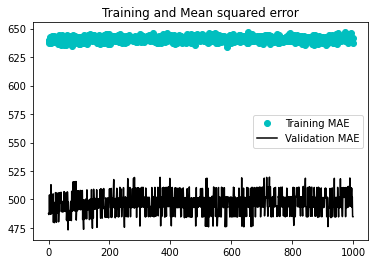

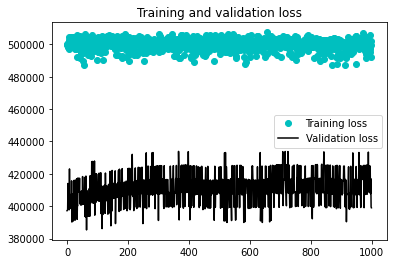

In [21]:

loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs_x = range(len(loss))

plt.plot(epochs_x, mae, 'co', label='Training MAE')
plt.plot(epochs_x, val_mae, 'k', label='Validation MAE')
plt.title('Training and Mean squared error')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
     

In [22]:
epochs_x

range(0, 1000)

#Download the model


In [23]:
os.makedirs('./content/drive/My Drive/new', exist_ok=True)
model.save('./content/drive/My Drive/new/regression_unfreeze_2e-2.h5')

In [24]:
from google.colab import files


In [25]:
files.download('./content/drive/My Drive/new/regression_unfreeze_2e-2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>